Running Clean Waveguide SHG Analysis...

📊 PAIR 1: Waveguide Structure Overview


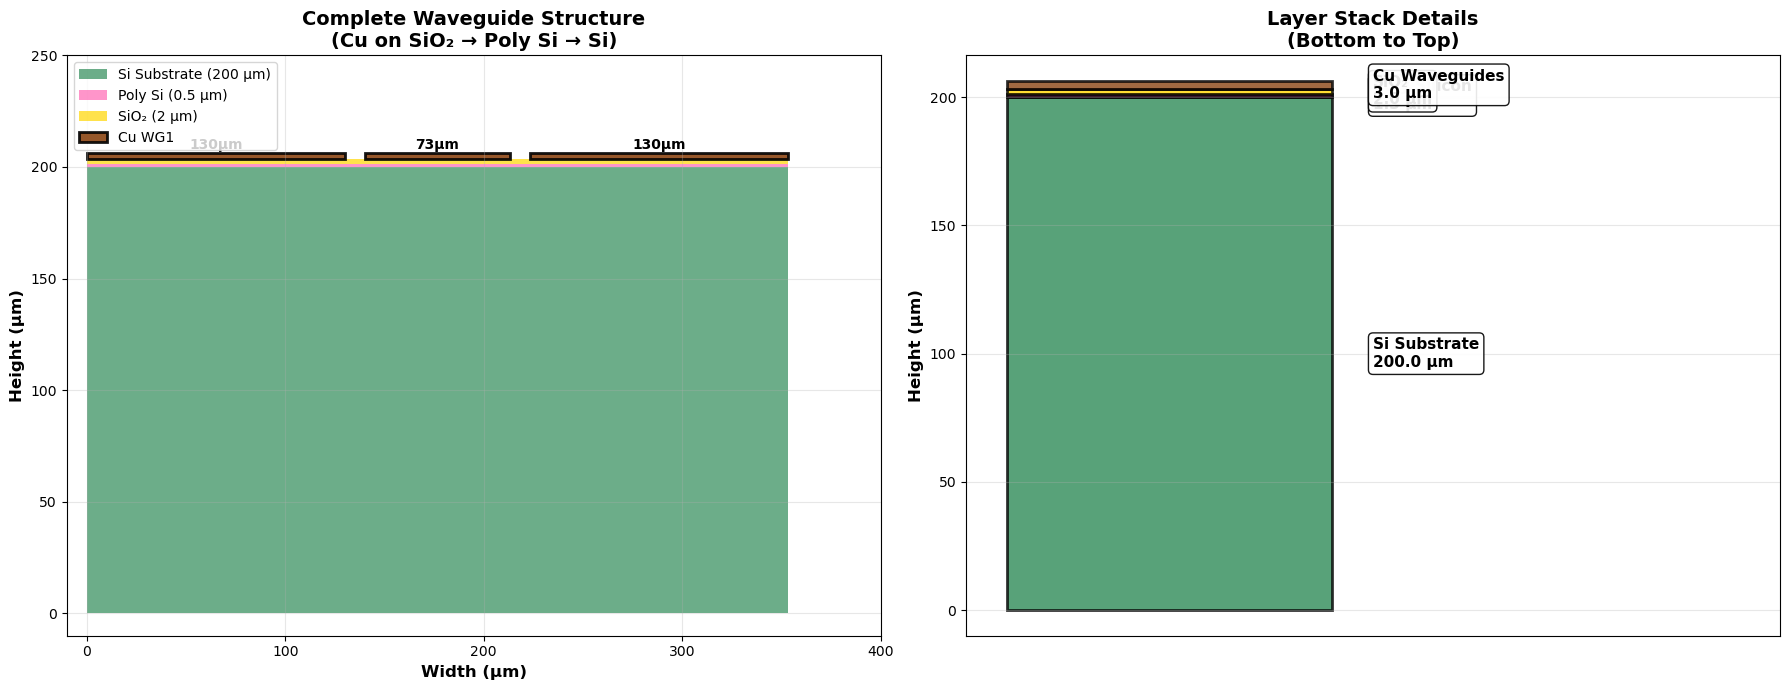


📊 PAIR 2: W2 Width Variations (15μm vs 120μm)


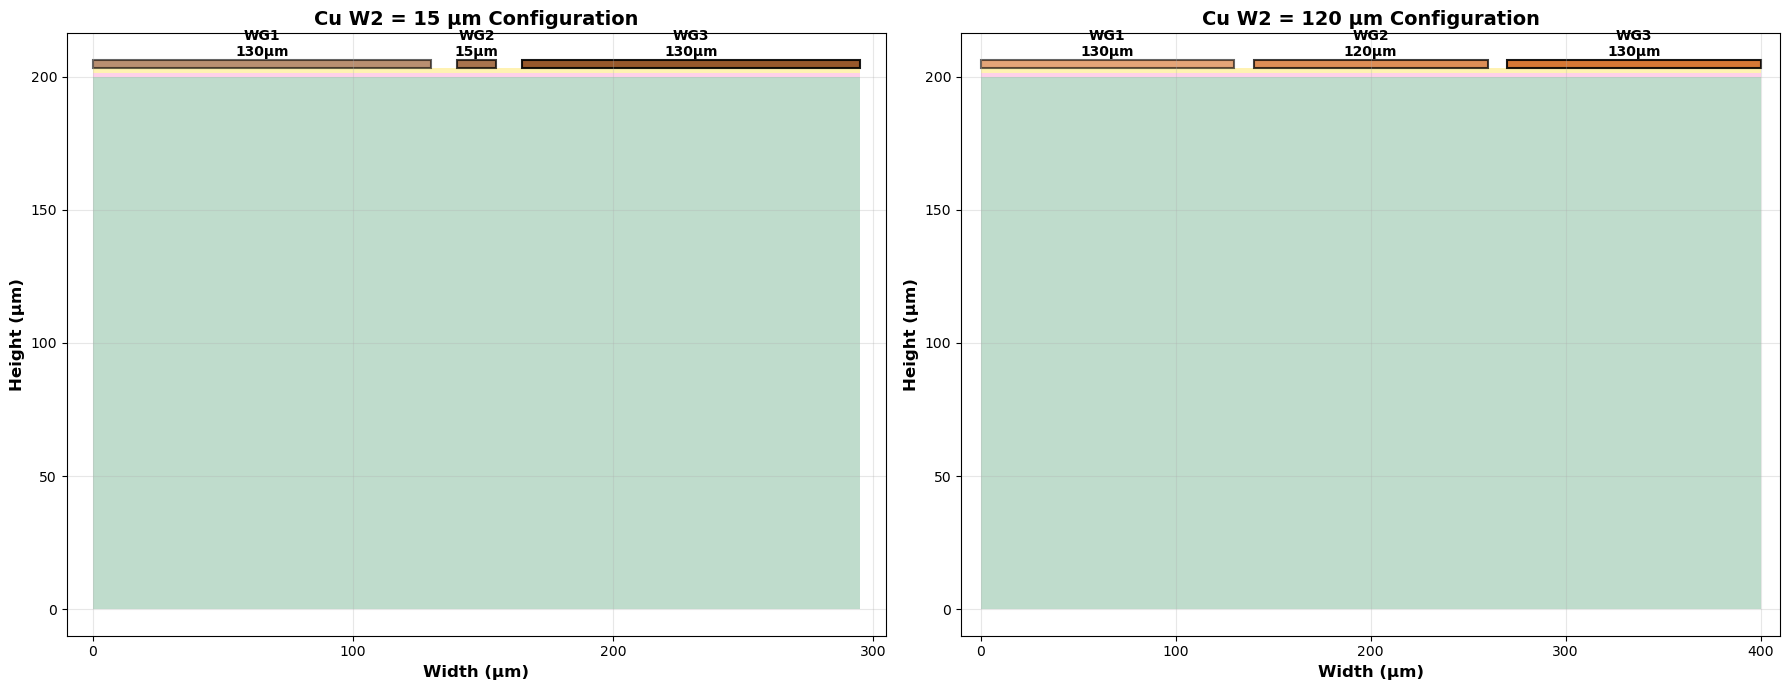


📊 PAIR 3: S-Parameters vs Frequency


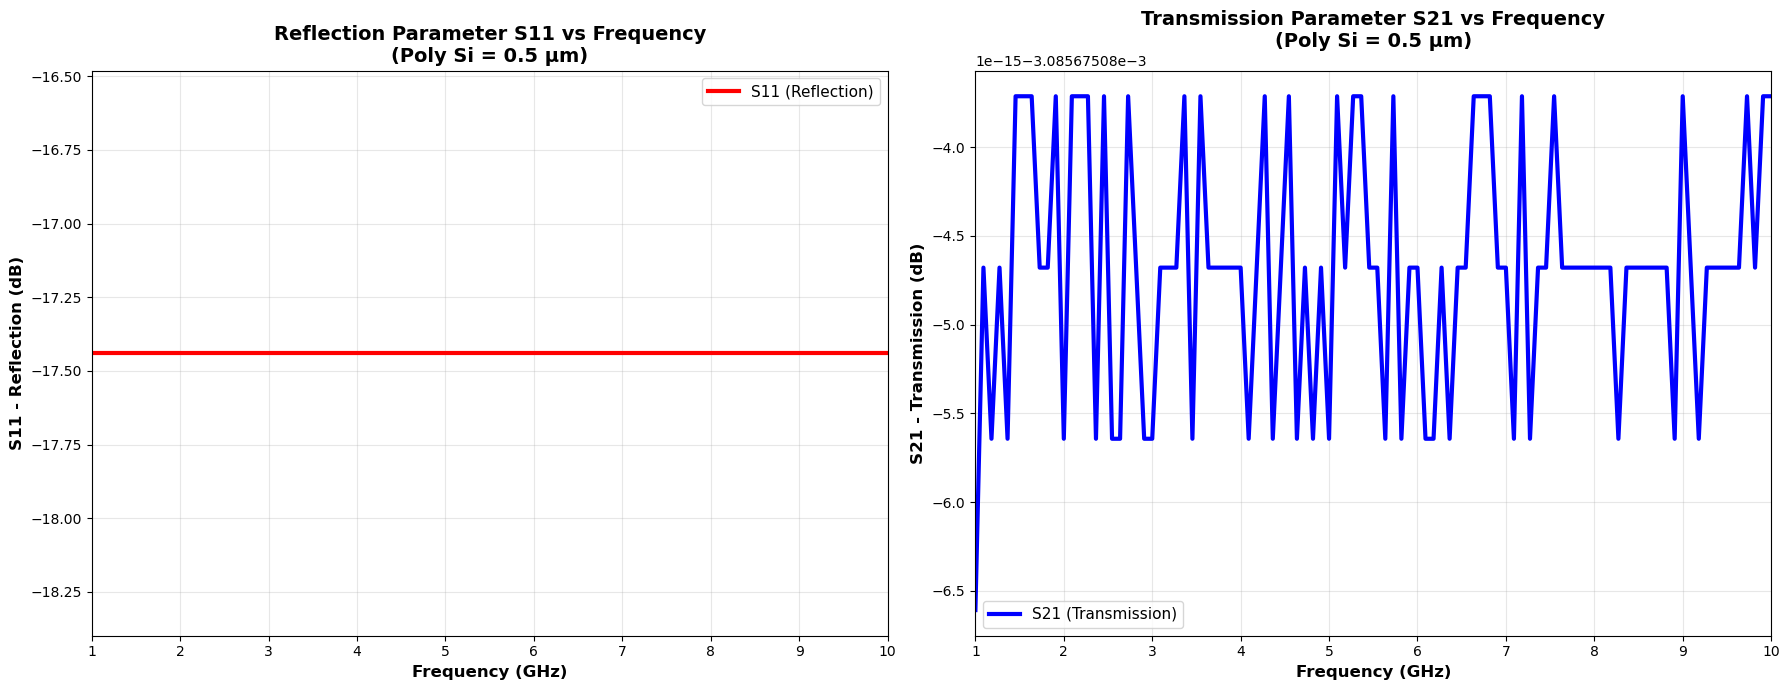


📊 PAIR 4: S-Parameters vs Poly Si Thickness


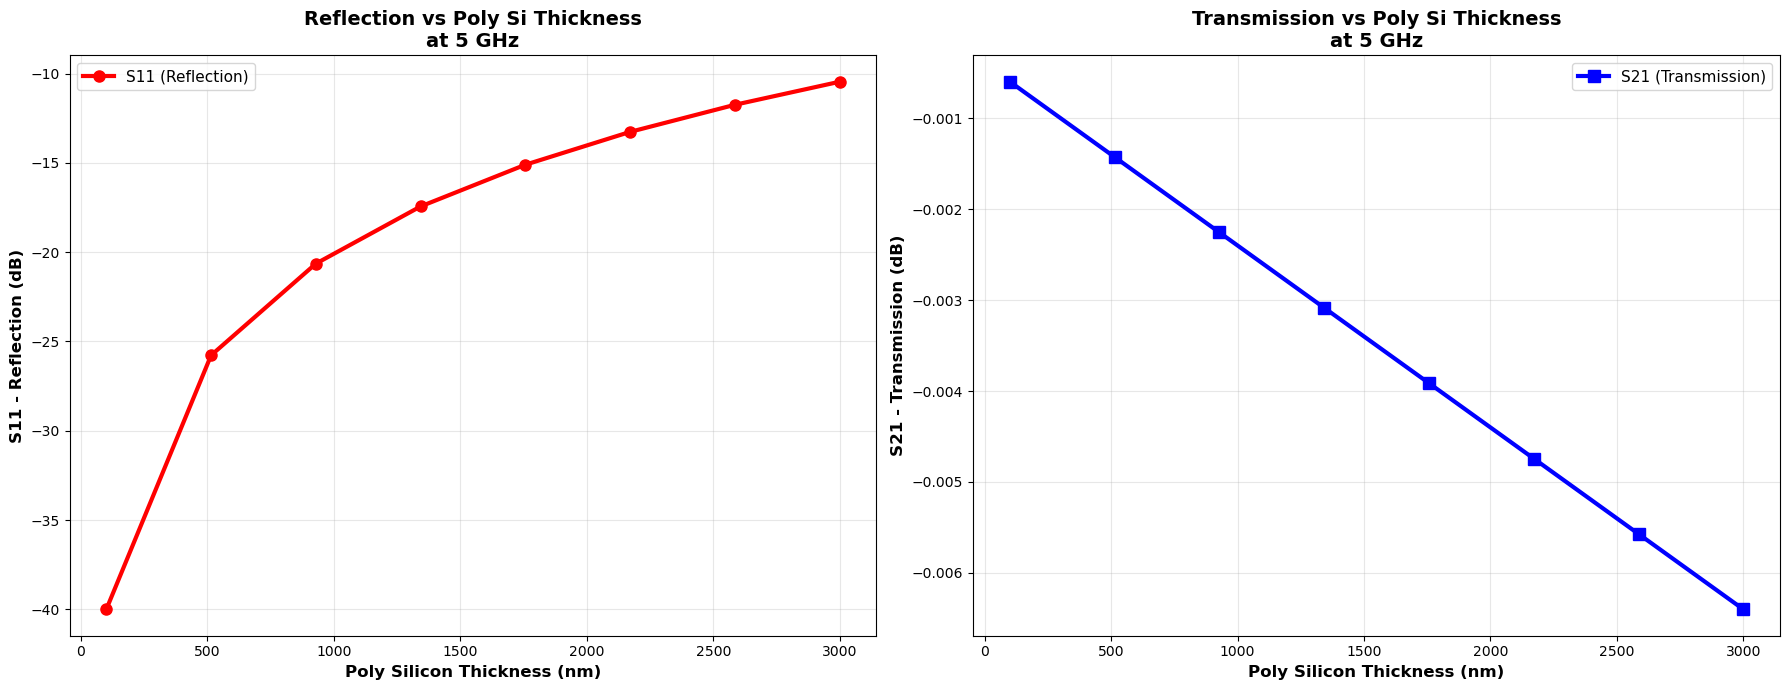


📊 PAIR 5: Second Harmonic Generation Analysis


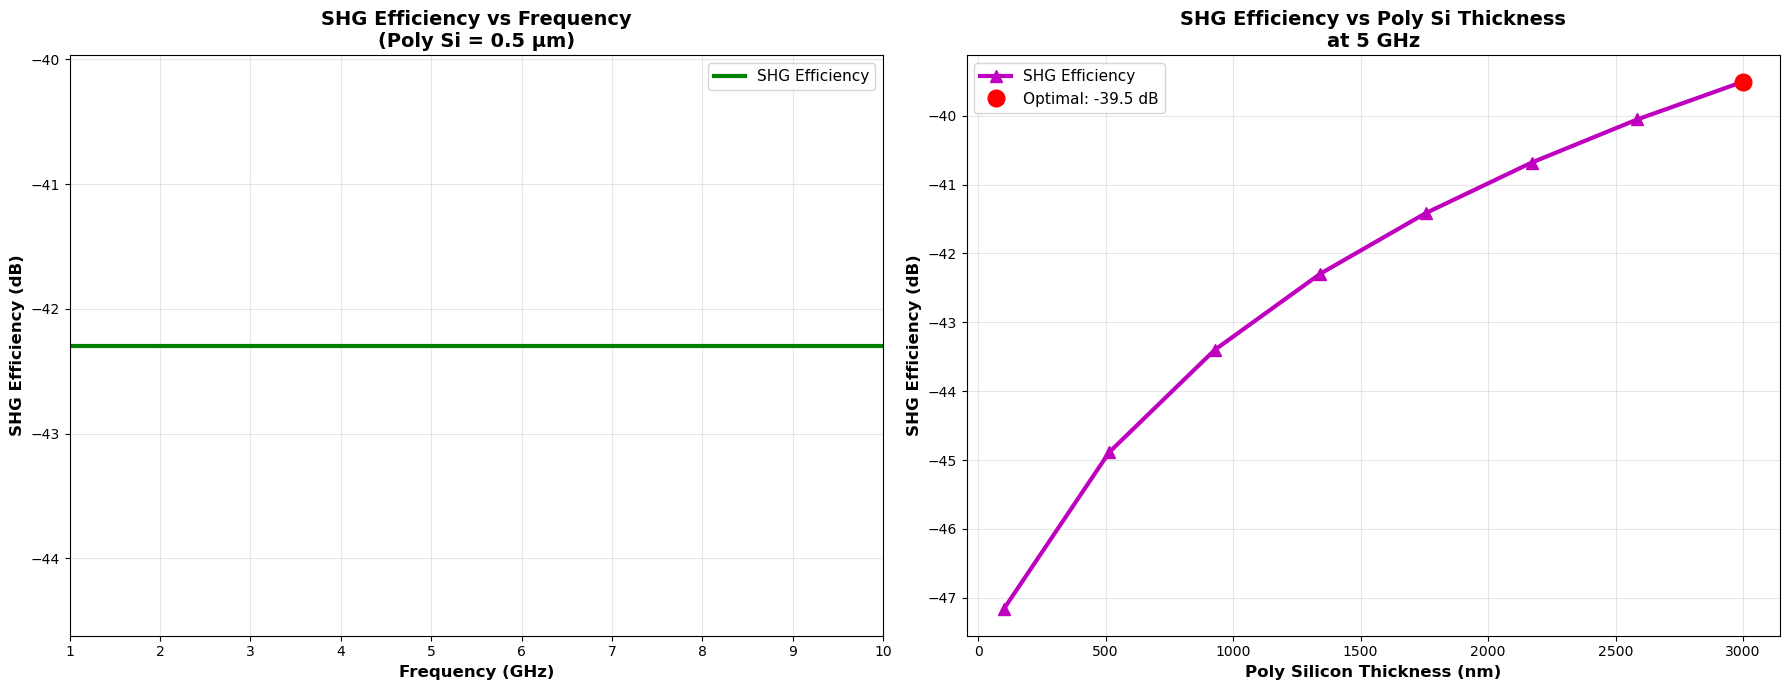


📊 PAIR 6: Material Properties


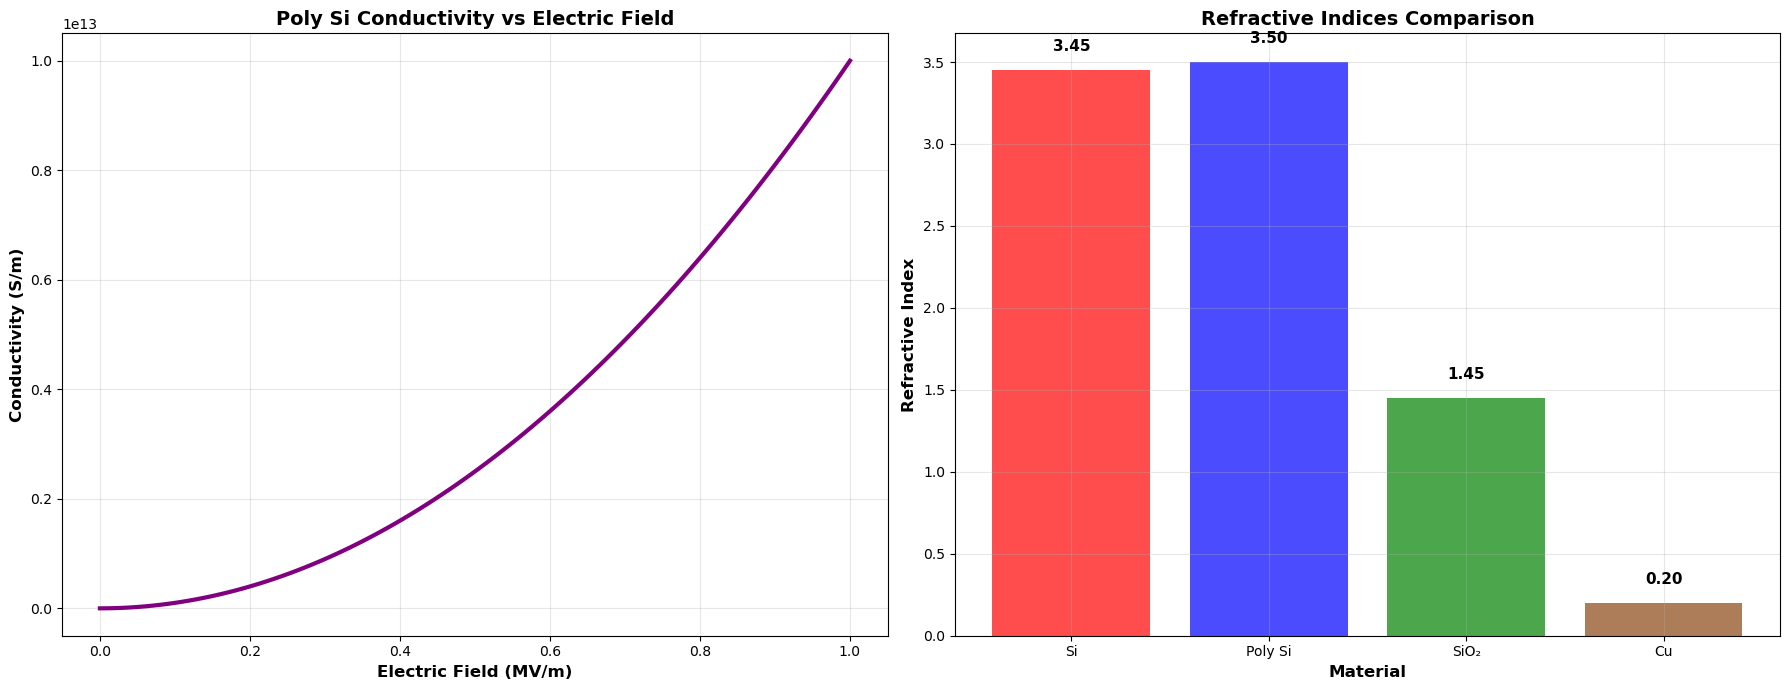


ANALYSIS COMPLETED SUCCESSFULLY!
All plots generated with clean layouts and no overlapping labels.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, epsilon_0, mu_0
import scipy.integrate as integrate
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches

class WaveguideSHG:
    def __init__(self):
        # Physical constants
        self.c = c
        self.epsilon_0 = epsilon_0
        self.mu_0 = mu_0
        
        # Material refractive indices
        self.n_si = 3.45  # Silicon
        self.n_polysi = 3.50  # Poly Silicon
        self.n_sio2 = 1.45  # SiO₂ (BOX)
        self.n_cu = 0.20 + 10.8j  # Copper (complex refractive index)
        
        # Waveguide dimensions
        self.W1 = 130e-6    # Width WG1
        self.W2_range = np.linspace(15e-6, 120e-6, 10)  # WG2 width range
        self.W3 = 130e-6    # Width WG3
        self.H = 3e-6       # Height all waveguides
        self.L = 4e-3       # Length all waveguides
        self.gap = 10e-6    # Gap between waveguides
        
        # Layer thicknesses - CORRECTED ORDER: Cu waveguides on SiO2 (first), then Si-Poly, then Si (bottom)
        self.t_box = 2e-6     # SiO2 thickness
        self.t_polysi_range = np.linspace(0.1e-6, 3e-6, 8)  # Poly Si thickness range
        self.t_si = 200e-6    # Si substrate thickness
        
        # Simulation parameters
        self.freq_range = np.linspace(1e9, 10e9, 100)  # 1-10 GHz
        self.voltage_range = np.linspace(-1, 1, 50)
        
    def conductivity_polysi(self, E_x, E_y):
        """Conductivity of Poly Silicon as function of electric field"""
        sigma_0 = 100  # Base conductivity (S/m)
        E_magnitude = np.sqrt(E_x**2 + E_y**2)
        field_factor = 1 + 0.1 * E_magnitude**2
        return sigma_0 * field_factor
    
    def calculate_propagation_constant(self, freq, width, material):
        """Calculate propagation constant for waveguide"""
        if material == 'si':
            n_eff = self.n_si
        elif material == 'polysi':
            n_eff = self.n_polysi
        elif material == 'sio2':
            n_eff = self.n_sio2
        
        wavelength = self.c / freq
        beta = 2 * np.pi * n_eff / wavelength
        return beta, n_eff
    
    def s_parameters_polysi_thickness(self, freq, width, t_polysi):
        """Calculate S-parameters with Poly Si thickness dependence"""
        beta_si, n_eff_si = self.calculate_propagation_constant(freq, width, 'si')
        beta_polysi, n_eff_polysi = self.calculate_propagation_constant(freq, width, 'polysi')
        
        L_eff = self.L
        alpha_db = 0.1 + 0.5 * (t_polysi/1e-6)
        alpha_np = alpha_db / 8.686
        
        beta_eff = (beta_si * (self.H - t_polysi) + beta_polysi * t_polysi) / self.H
        
        S21 = np.exp(-(alpha_np + 1j * beta_eff) * L_eff)
        S11 = 0.1 * (t_polysi/1e-6) * np.exp(1j * np.pi/4)
        
        return S11, S21
    
    def calculate_shg_efficiency(self, freq, width, t_polysi):
        """Calculate second harmonic generation efficiency"""
        L_eff = self.L
        beta_fund, n_eff_fund = self.calculate_propagation_constant(freq, width, 'si')
        beta_shg, n_eff_shg = self.calculate_propagation_constant(2*freq, width, 'si')
        
        delta_beta = 2 * beta_fund - beta_shg
        polysi_enhancement = 1 + 2.0 * (t_polysi/1e-6)
        
        if delta_beta == 0:
            shg_eff = L_eff**2 * polysi_enhancement
        else:
            shg_eff = (np.sin(delta_beta * L_eff / 2) / (delta_beta / 2))**2 * polysi_enhancement
        
        return shg_eff

    def plot_structure_pair_1(self):
        """Plot first pair: Detailed cross-section"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
        
        # Colors - Added Cu color
        layer_colors = {
            'si_substrate': '#2E8B57', 'sio2_box': '#FFD700', 
            'polysi': '#FF69B4', 'cu_wg': '#8B4513',
            'wg1': '#FF6B6B', 'wg2': '#4ECDC4', 'wg3': '#45B7D1'
        }
        
        W2 = self.W2_range[5]
        total_width = self.W1 + self.gap + W2 + self.gap + self.W3
        
        # Plot 1: Complete structure - CORRECTED LAYER ORDER
        # Cu waveguides on SiO2 (first), then Si-Poly, then Si (bottom)
        layers_height = self.t_si + self.t_polysi_range[3] + self.t_box + self.H
        
        # Draw layers in correct order from bottom to top
        # Si substrate (bottom)
        ax1.add_patch(patches.Rectangle((0, 0), total_width, self.t_si, 
                                      facecolor=layer_colors['si_substrate'], alpha=0.7, 
                                      label='Si Substrate (200 μm)'))
        # Poly Si layer (middle)
        ax1.add_patch(patches.Rectangle((0, self.t_si), total_width, self.t_polysi_range[3], 
                                      facecolor=layer_colors['polysi'], alpha=0.7, 
                                      label='Poly Si (0.5 μm)'))
        # SiO2 layer (top)
        ax1.add_patch(patches.Rectangle((0, self.t_si + self.t_polysi_range[3]), total_width, self.t_box, 
                                      facecolor=layer_colors['sio2_box'], alpha=0.7, 
                                      label='SiO₂ (2 μm)'))
        
        # Draw Cu waveguides (on top of SiO2)
        x_positions = [0, self.W1 + self.gap, self.W1 + self.gap + W2 + self.gap]
        widths = [self.W1, W2, self.W3]
        
        base_height = self.t_si + self.t_polysi_range[3] + self.t_box
        
        for i, (x, w) in enumerate(zip(x_positions, widths)):
            ax1.add_patch(patches.Rectangle((x, base_height), w, self.H, 
                                          facecolor=layer_colors['cu_wg'], alpha=0.9,
                                          edgecolor='black', linewidth=2,
                                          label=f'Cu WG{i+1}' if i == 0 else ""))
            
            # Clean width labels
            ax1.text(x + w/2, base_height + self.H + 0.2e-6, f'{w*1e6:.0f}μm', 
                    ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        ax1.set_xlabel('Width (μm)', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Height (μm)', fontsize=12, fontweight='bold')
        ax1.set_title('Complete Waveguide Structure\n(Cu on SiO₂ → Poly Si → Si)', fontsize=14, fontweight='bold')
        ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize=10)
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(-10e-6, total_width + 10e-6)
        ax1.set_ylim(-10e-6, layers_height + 10e-6)
        
        # Convert axes
        x_ticks = np.arange(0, total_width + 50e-6, 100e-6)
        ax1.set_xticks(x_ticks)
        ax1.set_xticklabels([f'{x*1e6:.0f}' for x in x_ticks])
        y_ticks = np.arange(0, layers_height + 50e-6, 50e-6)
        ax1.set_yticks(y_ticks)
        ax1.set_yticklabels([f'{y*1e6:.0f}' for y in y_ticks])
        
        # Plot 2: Layer focus - CORRECTED ORDER
        layers = [self.t_si, self.t_polysi_range[3], self.t_box, self.H]
        layer_names = ['Si Substrate', 'Poly Silicon', 'SiO₂', 'Cu Waveguides']
        colors = [layer_colors['si_substrate'], layer_colors['polysi'], 
                 layer_colors['sio2_box'], layer_colors['cu_wg']]
        
        y_pos = 0
        for i, (thickness, color, name) in enumerate(zip(layers, colors, layer_names)):
            ax2.add_patch(patches.Rectangle((0.1, y_pos), 0.8, thickness, 
                                          facecolor=color, alpha=0.8, 
                                          edgecolor='black', linewidth=2))
            
            ax2.text(1.0, y_pos + thickness/2, f'{name}\n{thickness*1e6:.1f} μm', 
                    ha='left', va='center', fontweight='bold', fontsize=11,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
            y_pos += thickness
        
        ax2.set_xlim(0, 2)
        ax2.set_ylim(-10e-6, y_pos + 10e-6)
        ax2.set_xlabel('')
        ax2.set_ylabel('Height (μm)', fontsize=12, fontweight='bold')
        ax2.set_title('Layer Stack Details\n(Bottom to Top)', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.set_xticks([])
        
        y_ticks = np.arange(0, y_pos + 20e-6, 50e-6)
        ax2.set_yticks(y_ticks)
        ax2.set_yticklabels([f'{y*1e6:.0f}' for y in y_ticks])
        
        plt.tight_layout()
        plt.show()

    def plot_structure_pair_2(self):
        """Plot second pair: W2 width variations"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
        
        # Select two different W2 values
        w2_cases = [0, 9]  # Minimum and maximum
        colors = ['#8B4513', '#D2691E']  # Copper colors
        
        for idx, (w2_idx, color) in enumerate(zip(w2_cases, colors)):
            ax = ax1 if idx == 0 else ax2
            W2 = self.W2_range[w2_idx]
            
            total_width = self.W1 + self.gap + W2 + self.gap + self.W3
            base_height = self.t_si + self.t_polysi_range[3] + self.t_box
            
            # Draw simplified structure with correct layer order
            # Si substrate
            ax.add_patch(patches.Rectangle((0, 0), total_width, self.t_si, 
                                         facecolor='#2E8B57', alpha=0.3))
            # Poly Si
            ax.add_patch(patches.Rectangle((0, self.t_si), total_width, self.t_polysi_range[3], 
                                         facecolor='#FF69B4', alpha=0.3))
            # SiO2
            ax.add_patch(patches.Rectangle((0, self.t_si + self.t_polysi_range[3]), total_width, self.t_box, 
                                         facecolor='#FFD700', alpha=0.3))
            
            # Draw Cu waveguides
            x_positions = [0, self.W1 + self.gap, self.W1 + self.gap + W2 + self.gap]
            widths = [self.W1, W2, self.W3]
            wg_labels = ['WG1', 'WG2', 'WG3']
            
            for i, (x, w, label) in enumerate(zip(x_positions, widths, wg_labels)):
                ax.add_patch(patches.Rectangle((x, base_height), w, self.H, 
                                             facecolor=color, alpha=0.6 + i*0.15,
                                             edgecolor='black', linewidth=1.5))
                
                ax.text(x + w/2, base_height + self.H + 0.3e-6, f'{label}\n{w*1e6:.0f}μm', 
                       ha='center', va='bottom', fontweight='bold', fontsize=10)
            
            ax.set_xlabel('Width (μm)', fontsize=12, fontweight='bold')
            ax.set_ylabel('Height (μm)', fontsize=12, fontweight='bold')
            ax.set_title(f'Cu W2 = {W2*1e6:.0f} μm Configuration', fontsize=14, fontweight='bold')
            ax.grid(True, alpha=0.3)
            
            ax.set_xlim(-10e-6, total_width + 10e-6)
            ax.set_ylim(-10e-6, base_height + self.H + 10e-6)
            
            x_ticks = np.arange(0, total_width + 50e-6, 100e-6)
            ax.set_xticks(x_ticks)
            ax.set_xticklabels([f'{x*1e6:.0f}' for x in x_ticks])
            
            y_ticks = np.arange(0, base_height + self.H + 20e-6, 50e-6)
            ax.set_yticks(y_ticks)
            ax.set_yticklabels([f'{y*1e6:.0f}' for y in y_ticks])
        
        plt.tight_layout()
        plt.show()

    def plot_s_parameters_pair_1(self):
        """Plot first S-parameters pair: Frequency response"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
        
        # Fixed Poly Si thickness
        t_polysi = self.t_polysi_range[3]
        
        S11_results = []
        S21_results = []
        
        for freq in self.freq_range:
            S11, S21 = self.s_parameters_polysi_thickness(freq, self.W1, t_polysi)
            S11_results.append(20*np.log10(np.abs(S11)))
            S21_results.append(20*np.log10(np.abs(S21)))
        
        # Plot S11
        ax1.plot(self.freq_range/1e9, S11_results, 'r-', linewidth=3, 
                label='S11 (Reflection)')
        ax1.set_xlabel('Frequency (GHz)', fontsize=12, fontweight='bold')
        ax1.set_ylabel('S11 - Reflection (dB)', fontsize=12, fontweight='bold')
        ax1.set_title('Reflection Parameter S11 vs Frequency\n(Poly Si = 0.5 μm)', 
                     fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(1, 10)
        
        # Plot S21
        ax2.plot(self.freq_range/1e9, S21_results, 'b-', linewidth=3, 
                label='S21 (Transmission)')
        ax2.set_xlabel('Frequency (GHz)', fontsize=12, fontweight='bold')
        ax2.set_ylabel('S21 - Transmission (dB)', fontsize=12, fontweight='bold')
        ax2.set_title('Transmission Parameter S21 vs Frequency\n(Poly Si = 0.5 μm)', 
                     fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(1, 10)
        
        plt.tight_layout()
        plt.show()

    def plot_s_parameters_pair_2(self):
        """Plot second S-parameters pair: Thickness dependence"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
        
        fixed_freq = 5e9
        
        S11_thickness = []
        S21_thickness = []
        
        for t_polysi in self.t_polysi_range:
            S11, S21 = self.s_parameters_polysi_thickness(fixed_freq, self.W1, t_polysi)
            S11_thickness.append(20*np.log10(np.abs(S11)))
            S21_thickness.append(20*np.log10(np.abs(S21)))
        
        # Plot S11 vs thickness
        ax1.plot(self.t_polysi_range*1e9, S11_thickness, 'ro-', linewidth=3, 
                markersize=8, label='S11 (Reflection)')
        ax1.set_xlabel('Poly Silicon Thickness (nm)', fontsize=12, fontweight='bold')
        ax1.set_ylabel('S11 - Reflection (dB)', fontsize=12, fontweight='bold')
        ax1.set_title('Reflection vs Poly Si Thickness\nat 5 GHz', 
                     fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        
        # Plot S21 vs thickness
        ax2.plot(self.t_polysi_range*1e9, S21_thickness, 'bs-', linewidth=3, 
                markersize=8, label='S21 (Transmission)')
        ax2.set_xlabel('Poly Silicon Thickness (nm)', fontsize=12, fontweight='bold')
        ax2.set_ylabel('S21 - Transmission (dB)', fontsize=12, fontweight='bold')
        ax2.set_title('Transmission vs Poly Si Thickness\nat 5 GHz', 
                     fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    def plot_shg_pair(self):
        """Plot SHG analysis pair"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
        
        fixed_freq = 5e9
        
        # SHG vs frequency
        shg_freq = []
        t_polysi = self.t_polysi_range[3]
        
        for freq in self.freq_range:
            eff = self.calculate_shg_efficiency(freq, self.W1, t_polysi)
            shg_freq.append(10*np.log10(eff + 1e-12))
        
        ax1.plot(self.freq_range/1e9, shg_freq, 'g-', linewidth=3, 
                label='SHG Efficiency')
        ax1.set_xlabel('Frequency (GHz)', fontsize=12, fontweight='bold')
        ax1.set_ylabel('SHG Efficiency (dB)', fontsize=12, fontweight='bold')
        ax1.set_title('SHG Efficiency vs Frequency\n(Poly Si = 0.5 μm)', 
                     fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(1, 10)
        
        # SHG vs thickness
        shg_thickness = []
        
        for t_polysi in self.t_polysi_range:
            eff = self.calculate_shg_efficiency(fixed_freq, self.W1, t_polysi)
            shg_thickness.append(10*np.log10(eff + 1e-12))
        
        ax2.plot(self.t_polysi_range*1e9, shg_thickness, 'm^-', linewidth=3, 
                markersize=8, label='SHG Efficiency')
        
        # Mark optimal point
        max_idx = np.argmax(shg_thickness)
        max_thickness = self.t_polysi_range[max_idx]*1e9
        max_eff = shg_thickness[max_idx]
        
        ax2.plot(max_thickness, max_eff, 'ro', markersize=12, 
                label=f'Optimal: {max_eff:.1f} dB')
        
        ax2.set_xlabel('Poly Silicon Thickness (nm)', fontsize=12, fontweight='bold')
        ax2.set_ylabel('SHG Efficiency (dB)', fontsize=12, fontweight='bold')
        ax2.set_title('SHG Efficiency vs Poly Si Thickness\nat 5 GHz', 
                     fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    def plot_material_properties_pair(self):
        """Plot material properties pair"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
        
        # Conductivity vs electric field
        E_range = np.linspace(0, 1e6, 100)
        conductivity = [self.conductivity_polysi(E, 0) for E in E_range]
        
        ax1.plot(E_range/1e6, conductivity, 'purple', linewidth=3)
        ax1.set_xlabel('Electric Field (MV/m)', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Conductivity (S/m)', fontsize=12, fontweight='bold')
        ax1.set_title('Poly Si Conductivity vs Electric Field', 
                     fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        
        # Refractive indices comparison
        materials = ['Si', 'Poly Si', 'SiO₂', 'Cu']
        n_values = [self.n_si, self.n_polysi, self.n_sio2, np.real(self.n_cu)]
        colors = ['red', 'blue', 'green', '#8B4513']
        
        bars = ax2.bar(materials, n_values, color=colors, alpha=0.7)
        ax2.set_xlabel('Material', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Refractive Index', fontsize=12, fontweight='bold')
        ax2.set_title('Refractive Indices Comparison', 
                     fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, value in zip(bars, n_values):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{value:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        plt.tight_layout()
        plt.show()

    def run_clean_analysis(self):
        """Run complete analysis with clean, non-overlapping plots"""
        print("Running Clean Waveguide SHG Analysis...")
        print("=" * 50)
        
        print("\n📊 PAIR 1: Waveguide Structure Overview")
        self.plot_structure_pair_1()
        
        print("\n📊 PAIR 2: W2 Width Variations (15μm vs 120μm)")
        self.plot_structure_pair_2()
        
        print("\n📊 PAIR 3: S-Parameters vs Frequency")
        self.plot_s_parameters_pair_1()
        
        print("\n📊 PAIR 4: S-Parameters vs Poly Si Thickness")
        self.plot_s_parameters_pair_2()
        
        print("\n📊 PAIR 5: Second Harmonic Generation Analysis")
        self.plot_shg_pair()
        
        print("\n📊 PAIR 6: Material Properties")
        self.plot_material_properties_pair()
        
        print("\n" + "=" * 50)
        print("ANALYSIS COMPLETED SUCCESSFULLY!")
        print("All plots generated with clean layouts and no overlapping labels.")

# Run the clean analysis
if __name__ == "__main__":
    wg_sim = WaveguideSHG()
    wg_sim.run_clean_analysis()